In [1]:
# 10분 뒤 최대 전압 예측 - 결과.ipynb 참조

import pandas as pd
import os
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np


sel_features = ['hour','RACK_VOLTAGE','RACK_MIN_CELL_VOLTAGE','RACK_MIN_CELL_TEMPERATURE',
                'RACK_MAX_CELL_TEMPERATURE','RACK_CURRENT','minute','RACK_CELL_TEMPERATURE_GAP',
                'RACK_MAX_CELL_VOLTAGE','RACK_CELL_VOLTAGE_AVERAGE','RACK_CELL_VOLTAGE_GAP','day',
                'RACK_SOC','RACK_CELL_TEMPERATURE_AVERAGE']

label = "RACK_MIN_CELL_TEMPERATURE"

def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [date.strftime("%Y%m%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates

train_dates = date_range("20211001", "20220430")

path = "./forecasting_data/"

train = pd.DataFrame()

for train_date in train_dates:
    try:
        ess_data = pd.read_feather(path + train_date + "/rack.feather")[sel_features]

        train = pd.concat([train, ess_data], axis=0)
    except:
        pass

trainX = train.iloc[:-600,:]
trainY = train.reset_index(drop=True).loc[600:,label].reset_index(drop=True)

In [2]:
from datetime import datetime
import numpy as np



def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [date.strftime("%Y%m%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates

valid_dates = date_range("20220501", "20220630")

path = "./forecasting_data/"

valid = pd.DataFrame()

for valid_date in valid_dates:
    try:
        ess_data = pd.read_feather(path + valid_date + "/rack.feather")[sel_features]
        valid = pd.concat([valid, ess_data], axis=0)
    except:
        pass

validX = valid.iloc[:-600,:]
validY = valid.reset_index(drop=True).loc[600:,label].reset_index(drop=True)

In [3]:
lightGBM_param = {"learning_rate"                    : 0.05, 
                  "num_leaves"                       : 255,
                  "colsample_bytree"                 : 0.8466655445017455,
                  "subsample"                        : 0.8363223383173761,
                  "verbosity"                        : -1,
                  "random_state"                     : 42,
                  "objective"                        : "regression",
                  "metric"                           : "l2",
                  "num_threads"                      : 10,
                  "min_sum_hessian_in_leaf"          : 0.3139754544772033,
                  "reg_alpha"                        : 1.3918976712256577e-07,
                  "reg_lambda"                       : 0.015222751757854997,
                  "n_estimators"                     : 1000,
                  "max_depth "                       : 10
                 }

XGBoost_param = {"max_depth" : 4,
                 "learning_rate": 0.10261711125039377,
                 "n_estimators": 2000,
                 "colsample_bytree": 0.8306482536182962,
                 "colsample_bylevel": 0.5200894204312736,
                 "colsample_bynode": 0.9125155627018552,
                 "reg_lambda": 0.29449215771684206,
                 "reg_alpha": 0.019867959415002325,
                 "subsample": 0.85,
                 "min_child_weight": 9,
                 "gamma" : 0.1010776765952064,
                 "tree_method" : 'gpu_hist', 
                 "gpu_id" : 0
                }

#trainX = train.iloc[:-600,:].drop(["TIMESTAMP","BANK_ID","RACK_ID"], axis=1)
#trainY = train.reset_index(drop=True).loc[600:,"RACK_MAX_CELL_VOLTAGE"].reset_index(drop=True)

trainX, trainY = trainX.apply(pd.to_numeric), trainY.apply(pd.to_numeric)
validX, validY = validX.apply(pd.to_numeric), validY.apply(pd.to_numeric)

In [4]:
from lightgbm import LGBMRegressor

lgb_model = LGBMRegressor(**lightGBM_param)
lgb_model.fit(trainX, trainY)

[LightGBM] [Warning] max_depth is set=-1, max_depth= will be ignored. Current value: max_depth=-1
[LightGBM] [Warning] Unknown parameter: 10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.3139754544772033, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.3139754544772033
[LightGBM] [Warning] num_threads is set=10, n_jobs=-1 will be ignored. Current value: num_threads=10


LGBMRegressor(colsample_bytree=0.8466655445017455, learning_rate=0.05,
              max_depth =10, metric='l2',
              min_sum_hessian_in_leaf=0.3139754544772033, n_estimators=1000,
              num_leaves=255, num_threads=10, objective='regression',
              random_state=42, reg_alpha=1.3918976712256577e-07,
              reg_lambda=0.015222751757854997, subsample=0.8363223383173761,
              verbosity=-1)

In [5]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(**XGBoost_param)
xgb_model.fit(trainX,trainY)

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.5200894204312736,
             colsample_bynode=0.9125155627018552,
             colsample_bytree=0.8306482536182962, enable_categorical=False,
             gamma=0.1010776765952064, gpu_id=0, importance_type=None,
             interaction_constraints='', learning_rate=0.10261711125039377,
             max_delta_step=0, max_depth=4, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.019867959415002325, reg_lambda=0.29449215771684206,
             scale_pos_weight=1, subsample=0.85, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

In [6]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression().fit(trainX, trainY)

In [7]:
from catboost import CatBoostRegressor

cat_model = CatBoostRegressor(task_type="GPU", devices='0:1').fit(trainX, trainY)

Learning rate set to 0.144712
0:	learn: 2.5484123	total: 204ms	remaining: 3m 23s
1:	learn: 2.1995669	total: 282ms	remaining: 2m 20s
2:	learn: 1.9002501	total: 360ms	remaining: 1m 59s
3:	learn: 1.6420303	total: 438ms	remaining: 1m 48s
4:	learn: 1.4205371	total: 513ms	remaining: 1m 42s
5:	learn: 1.2312464	total: 598ms	remaining: 1m 39s
6:	learn: 1.0656583	total: 674ms	remaining: 1m 35s
7:	learn: 0.9243295	total: 748ms	remaining: 1m 32s
8:	learn: 0.8034298	total: 822ms	remaining: 1m 30s
9:	learn: 0.6993001	total: 897ms	remaining: 1m 28s
10:	learn: 0.6110094	total: 971ms	remaining: 1m 27s
11:	learn: 0.5353265	total: 1.04s	remaining: 1m 25s
12:	learn: 0.4700192	total: 1.12s	remaining: 1m 25s
13:	learn: 0.4144123	total: 1.2s	remaining: 1m 24s
14:	learn: 0.3670961	total: 1.27s	remaining: 1m 23s
15:	learn: 0.3265837	total: 1.35s	remaining: 1m 22s
16:	learn: 0.2927133	total: 1.43s	remaining: 1m 22s
17:	learn: 0.2638016	total: 1.5s	remaining: 1m 21s
18:	learn: 0.2396385	total: 1.57s	remaining: 1

157:	learn: 0.0781677	total: 13.5s	remaining: 1m 11s
158:	learn: 0.0781108	total: 13.6s	remaining: 1m 11s
159:	learn: 0.0779997	total: 13.6s	remaining: 1m 11s
160:	learn: 0.0778683	total: 13.7s	remaining: 1m 11s
161:	learn: 0.0777923	total: 13.8s	remaining: 1m 11s
162:	learn: 0.0777249	total: 13.9s	remaining: 1m 11s
163:	learn: 0.0776817	total: 14s	remaining: 1m 11s
164:	learn: 0.0776363	total: 14.1s	remaining: 1m 11s
165:	learn: 0.0776008	total: 14.3s	remaining: 1m 11s
166:	learn: 0.0775462	total: 14.3s	remaining: 1m 11s
167:	learn: 0.0774866	total: 14.4s	remaining: 1m 11s
168:	learn: 0.0773901	total: 14.5s	remaining: 1m 11s
169:	learn: 0.0772899	total: 14.6s	remaining: 1m 11s
170:	learn: 0.0772551	total: 14.7s	remaining: 1m 11s
171:	learn: 0.0771421	total: 14.8s	remaining: 1m 11s
172:	learn: 0.0770613	total: 14.9s	remaining: 1m 11s
173:	learn: 0.0770089	total: 15s	remaining: 1m 10s
174:	learn: 0.0769602	total: 15s	remaining: 1m 10s
175:	learn: 0.0769129	total: 15.1s	remaining: 1m 10s

316:	learn: 0.0649582	total: 26.3s	remaining: 56.6s
317:	learn: 0.0649374	total: 26.5s	remaining: 56.9s
318:	learn: 0.0649222	total: 26.7s	remaining: 57s
319:	learn: 0.0649070	total: 27s	remaining: 57.4s
320:	learn: 0.0648804	total: 27.1s	remaining: 57.4s
321:	learn: 0.0648581	total: 27.2s	remaining: 57.3s
322:	learn: 0.0645298	total: 27.3s	remaining: 57.3s
323:	learn: 0.0645110	total: 27.4s	remaining: 57.2s
324:	learn: 0.0644921	total: 27.5s	remaining: 57.1s
325:	learn: 0.0644693	total: 27.6s	remaining: 57s
326:	learn: 0.0644328	total: 27.7s	remaining: 56.9s
327:	learn: 0.0644140	total: 27.7s	remaining: 56.8s
328:	learn: 0.0641522	total: 27.8s	remaining: 56.8s
329:	learn: 0.0639552	total: 27.9s	remaining: 56.7s
330:	learn: 0.0639390	total: 28s	remaining: 56.6s
331:	learn: 0.0639158	total: 28.1s	remaining: 56.5s
332:	learn: 0.0638950	total: 28.2s	remaining: 56.4s
333:	learn: 0.0638672	total: 28.2s	remaining: 56.3s
334:	learn: 0.0638337	total: 28.3s	remaining: 56.2s
335:	learn: 0.063808

475:	learn: 0.0583289	total: 39.7s	remaining: 43.7s
476:	learn: 0.0583131	total: 39.8s	remaining: 43.7s
477:	learn: 0.0583003	total: 39.9s	remaining: 43.6s
478:	learn: 0.0582730	total: 40.1s	remaining: 43.6s
479:	learn: 0.0582563	total: 40.1s	remaining: 43.5s
480:	learn: 0.0581308	total: 40.2s	remaining: 43.4s
481:	learn: 0.0581249	total: 40.3s	remaining: 43.3s
482:	learn: 0.0581109	total: 40.4s	remaining: 43.2s
483:	learn: 0.0580538	total: 40.4s	remaining: 43.1s
484:	learn: 0.0580472	total: 40.5s	remaining: 43s
485:	learn: 0.0580362	total: 40.6s	remaining: 42.9s
486:	learn: 0.0580246	total: 40.7s	remaining: 42.8s
487:	learn: 0.0579828	total: 40.7s	remaining: 42.7s
488:	learn: 0.0579158	total: 40.8s	remaining: 42.7s
489:	learn: 0.0579055	total: 40.9s	remaining: 42.6s
490:	learn: 0.0578785	total: 41s	remaining: 42.5s
491:	learn: 0.0578592	total: 41s	remaining: 42.4s
492:	learn: 0.0578378	total: 41.1s	remaining: 42.3s
493:	learn: 0.0578312	total: 41.2s	remaining: 42.2s
494:	learn: 0.0578

635:	learn: 0.0550864	total: 52.4s	remaining: 30s
636:	learn: 0.0550545	total: 52.4s	remaining: 29.9s
637:	learn: 0.0550395	total: 52.5s	remaining: 29.8s
638:	learn: 0.0550304	total: 52.6s	remaining: 29.7s
639:	learn: 0.0550204	total: 52.7s	remaining: 29.6s
640:	learn: 0.0550040	total: 52.8s	remaining: 29.6s
641:	learn: 0.0549968	total: 52.9s	remaining: 29.5s
642:	learn: 0.0549908	total: 52.9s	remaining: 29.4s
643:	learn: 0.0549819	total: 53s	remaining: 29.3s
644:	learn: 0.0549719	total: 53.1s	remaining: 29.2s
645:	learn: 0.0549649	total: 53.2s	remaining: 29.1s
646:	learn: 0.0548349	total: 53.3s	remaining: 29.1s
647:	learn: 0.0546943	total: 53.3s	remaining: 29s
648:	learn: 0.0546899	total: 53.4s	remaining: 28.9s
649:	learn: 0.0546805	total: 53.5s	remaining: 28.8s
650:	learn: 0.0546691	total: 53.6s	remaining: 28.7s
651:	learn: 0.0546623	total: 53.6s	remaining: 28.6s
652:	learn: 0.0546309	total: 53.7s	remaining: 28.5s
653:	learn: 0.0546195	total: 53.8s	remaining: 28.5s
654:	learn: 0.0546

795:	learn: 0.0528420	total: 1m 5s	remaining: 16.7s
796:	learn: 0.0528396	total: 1m 5s	remaining: 16.6s
797:	learn: 0.0528344	total: 1m 5s	remaining: 16.6s
798:	learn: 0.0528299	total: 1m 5s	remaining: 16.5s
799:	learn: 0.0528211	total: 1m 5s	remaining: 16.4s
800:	learn: 0.0528164	total: 1m 5s	remaining: 16.3s
801:	learn: 0.0528089	total: 1m 5s	remaining: 16.2s
802:	learn: 0.0528031	total: 1m 5s	remaining: 16.1s
803:	learn: 0.0527988	total: 1m 5s	remaining: 16.1s
804:	learn: 0.0527941	total: 1m 5s	remaining: 16s
805:	learn: 0.0527865	total: 1m 6s	remaining: 15.9s
806:	learn: 0.0527796	total: 1m 6s	remaining: 15.8s
807:	learn: 0.0527665	total: 1m 6s	remaining: 15.7s
808:	learn: 0.0527582	total: 1m 6s	remaining: 15.6s
809:	learn: 0.0527346	total: 1m 6s	remaining: 15.6s
810:	learn: 0.0527229	total: 1m 6s	remaining: 15.5s
811:	learn: 0.0527185	total: 1m 6s	remaining: 15.4s
812:	learn: 0.0527134	total: 1m 6s	remaining: 15.3s
813:	learn: 0.0527097	total: 1m 6s	remaining: 15.2s
814:	learn: 0.

952:	learn: 0.0515089	total: 1m 17s	remaining: 3.85s
953:	learn: 0.0515030	total: 1m 18s	remaining: 3.76s
954:	learn: 0.0514944	total: 1m 18s	remaining: 3.68s
955:	learn: 0.0514891	total: 1m 18s	remaining: 3.6s
956:	learn: 0.0514803	total: 1m 18s	remaining: 3.52s
957:	learn: 0.0514744	total: 1m 18s	remaining: 3.44s
958:	learn: 0.0514698	total: 1m 18s	remaining: 3.36s
959:	learn: 0.0514635	total: 1m 18s	remaining: 3.28s
960:	learn: 0.0514597	total: 1m 18s	remaining: 3.2s
961:	learn: 0.0514548	total: 1m 18s	remaining: 3.11s
962:	learn: 0.0514498	total: 1m 18s	remaining: 3.03s
963:	learn: 0.0514446	total: 1m 19s	remaining: 2.95s
964:	learn: 0.0514380	total: 1m 19s	remaining: 2.87s
965:	learn: 0.0514325	total: 1m 19s	remaining: 2.79s
966:	learn: 0.0514301	total: 1m 19s	remaining: 2.7s
967:	learn: 0.0514257	total: 1m 19s	remaining: 2.62s
968:	learn: 0.0514221	total: 1m 19s	remaining: 2.54s
969:	learn: 0.0514180	total: 1m 19s	remaining: 2.46s
970:	learn: 0.0514128	total: 1m 19s	remaining: 2.

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

lgb_pred = lgb_model.predict(validX[sel_features])
xgb_pred = xgb_model.predict(validX[sel_features])
linear_pred = linear_reg.predict(validX[sel_features])
cat_pred = cat_model.predict(validX[sel_features])

print(f"LightGBM loss(MSE) : {mean_squared_error(validY,lgb_pred)}")
print(f"XGBoost loss(MSE)  : {mean_squared_error(validY,xgb_pred)}")
print(f"Linear loss(MSE)  : {mean_squared_error(validY,linear_pred)}")
print(f"CatBoost loss(MSE)  : {mean_squared_error(validY,cat_pred)}")
print()

print(f"LightGBM loss(MAE) : {mean_absolute_error(validY,lgb_pred)}")
print(f"XGBoost loss(MAE)  : {mean_absolute_error(validY,xgb_pred)}")
print(f"Linear loss(MAE)  : {mean_absolute_error(validY,linear_pred)}")
print(f"CatBoost loss(MAE)  : {mean_absolute_error(validY,cat_pred)}")

LightGBM loss(MSE) : 0.012500437156095614
XGBoost loss(MSE)  : 0.025120850901427374
Linear loss(MSE)  : 0.023268569411272762
CatBoost loss(MSE)  : 0.011018815839867937

LightGBM loss(MAE) : 0.055475679696645824
XGBoost loss(MAE)  : 0.09398624128001848
Linear loss(MAE)  : 0.09596383883815945
CatBoost loss(MAE)  : 0.048129855524347794


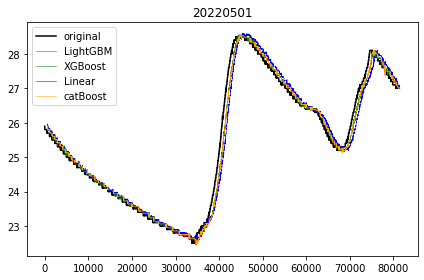

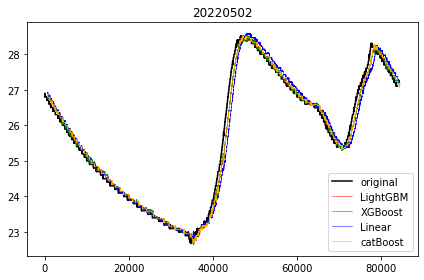

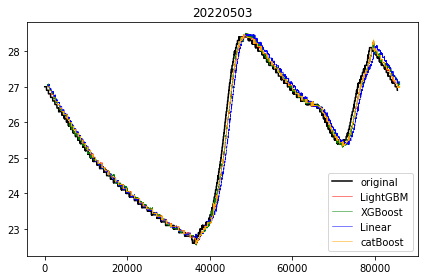

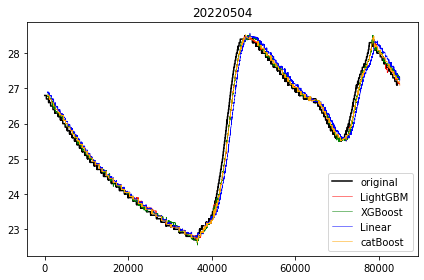

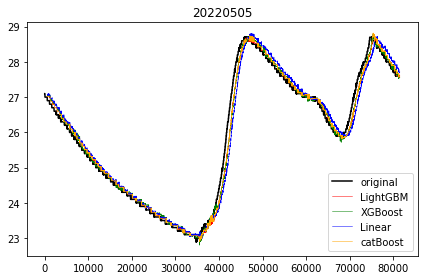

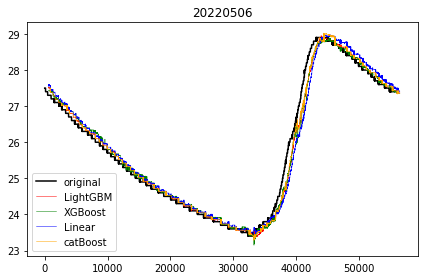

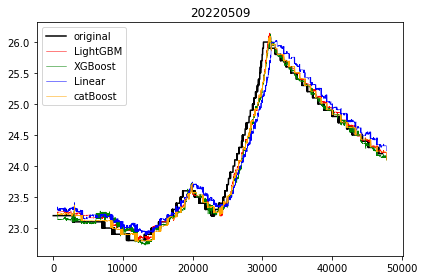

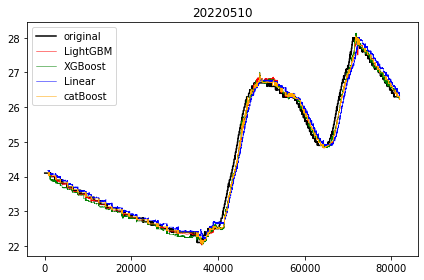

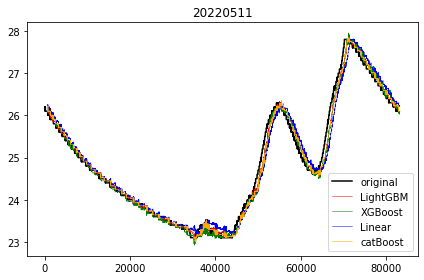

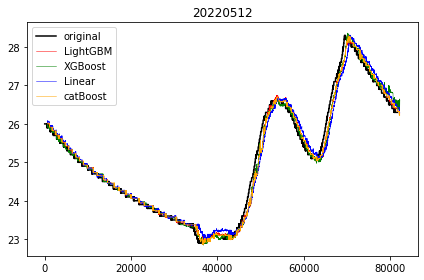

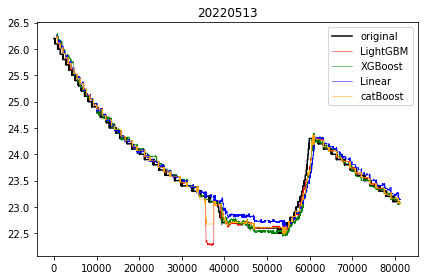

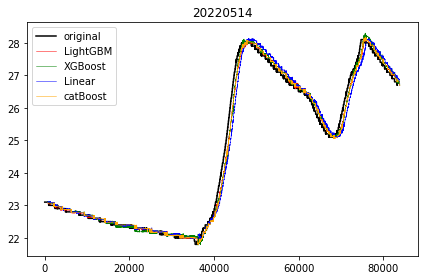

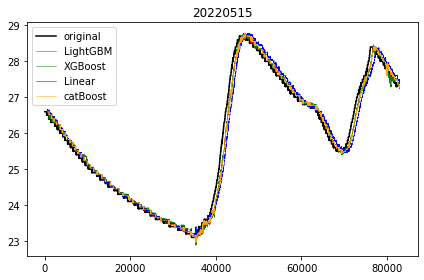

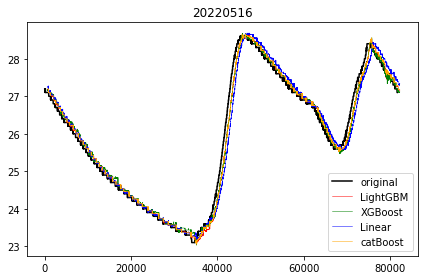

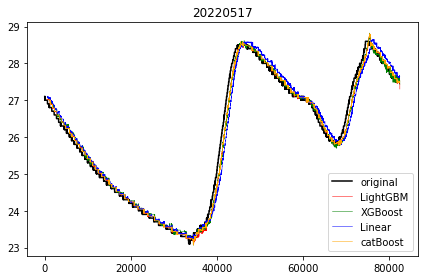

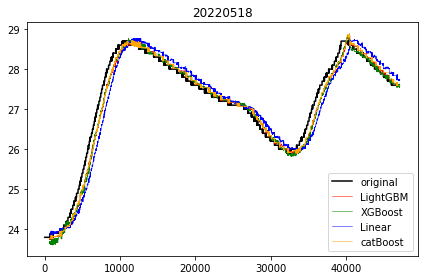

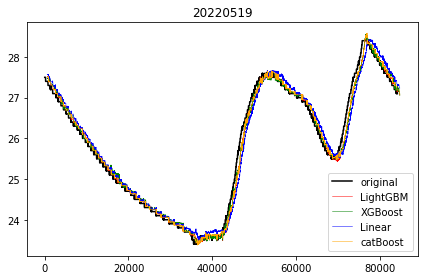

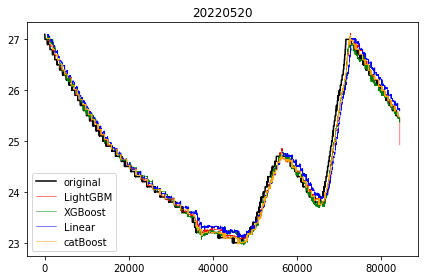

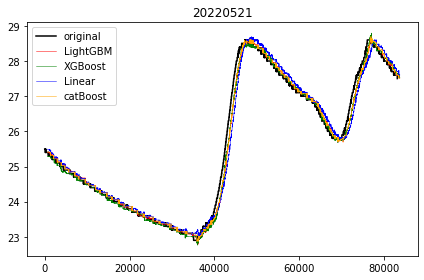

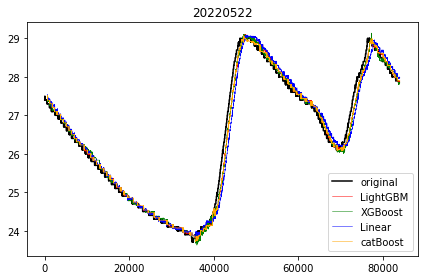

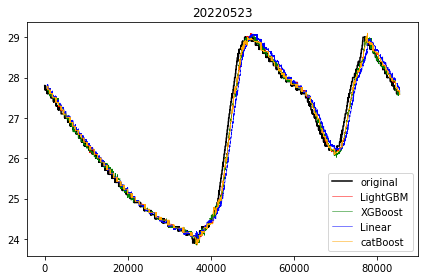

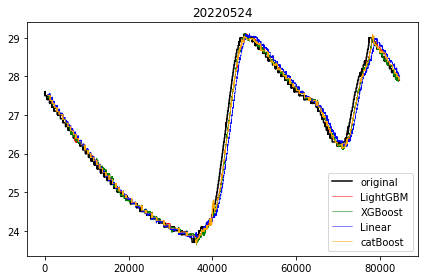

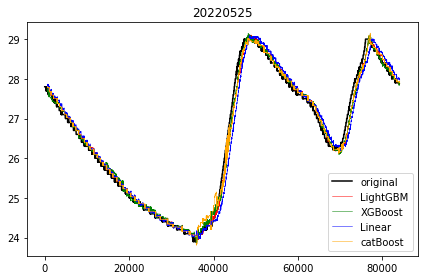

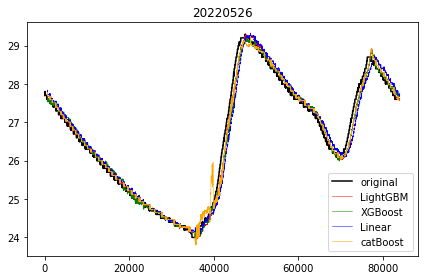

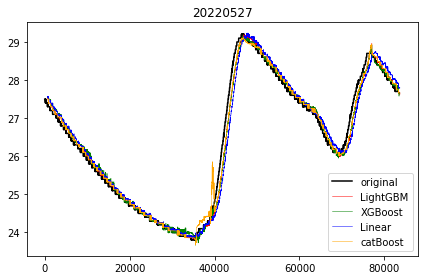

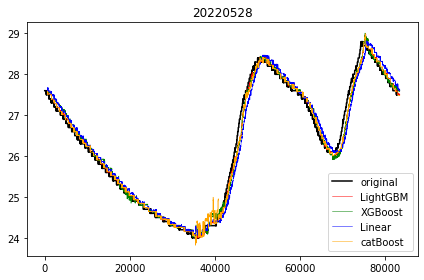

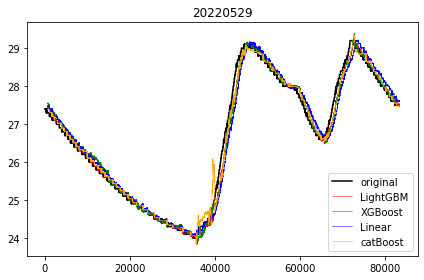

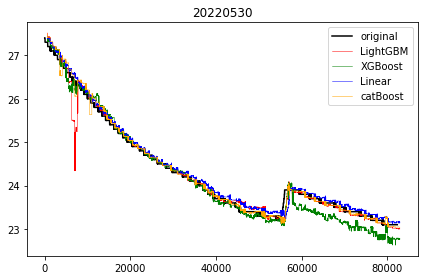

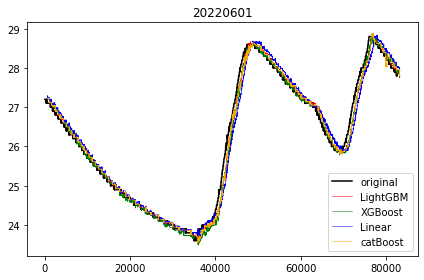

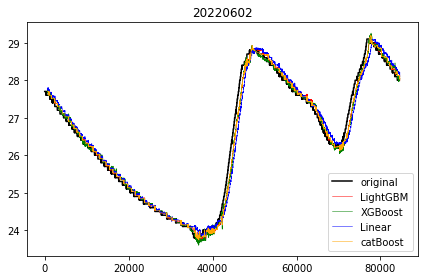

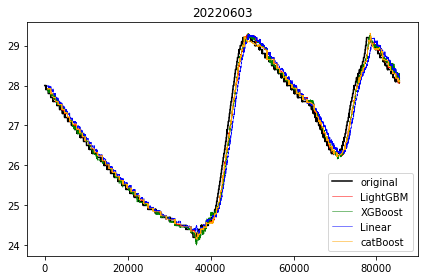

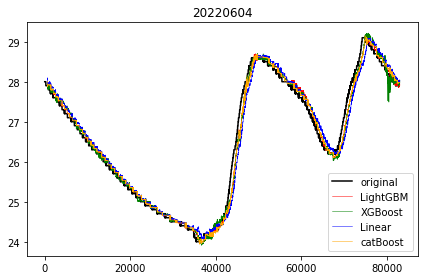

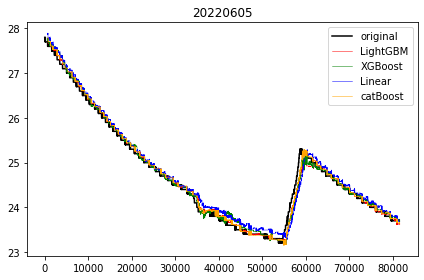

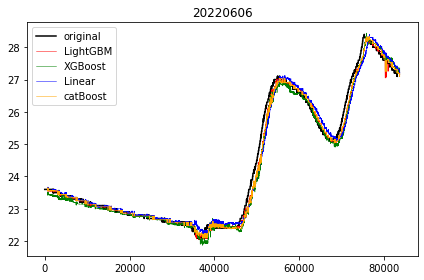

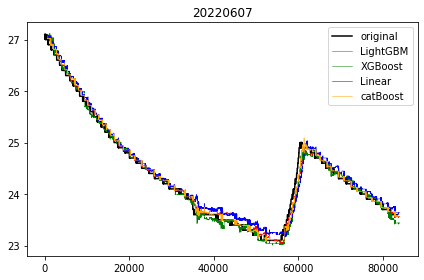

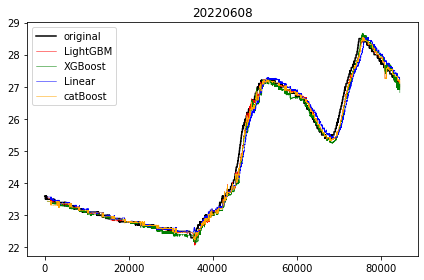

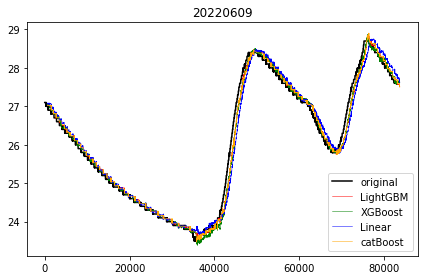

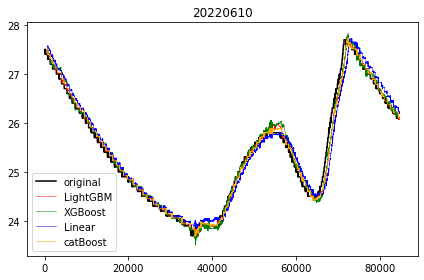

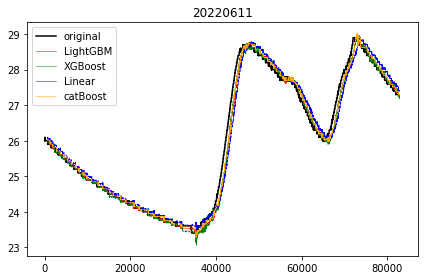

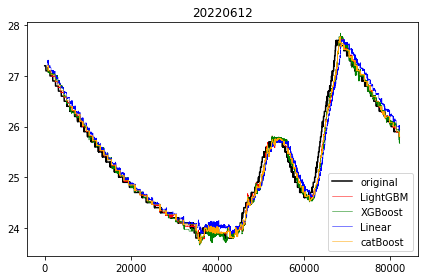

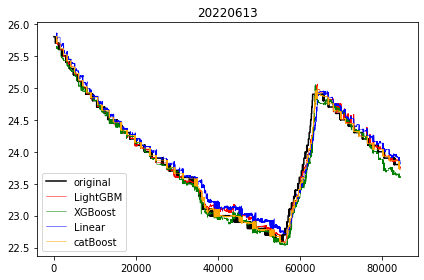

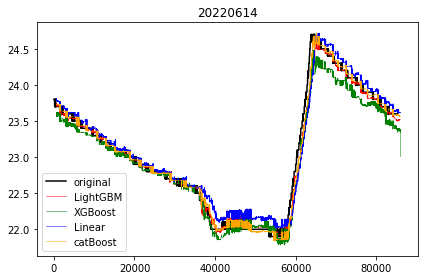

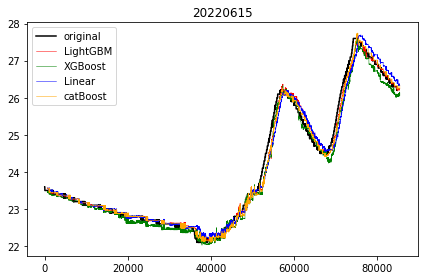

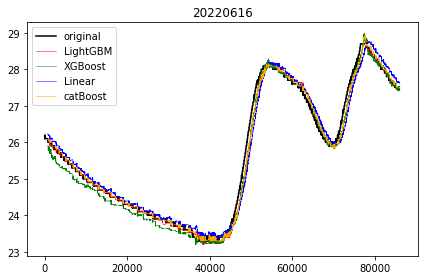

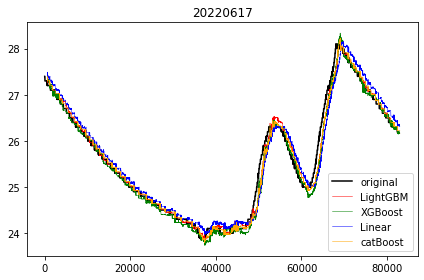

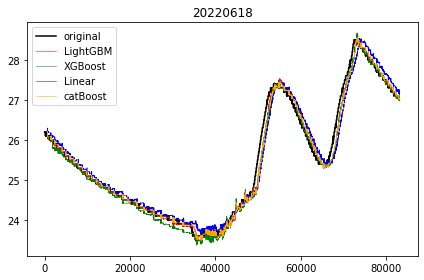

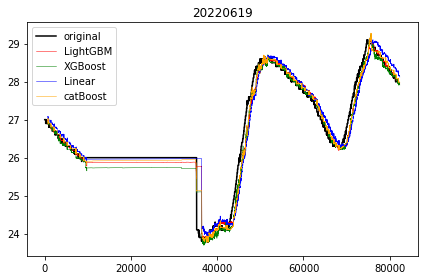

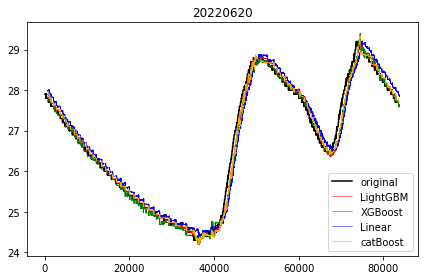

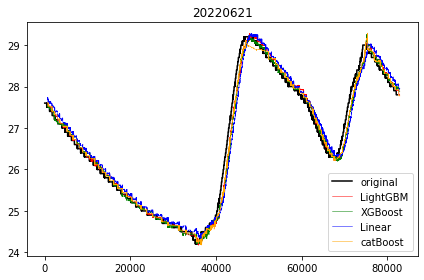

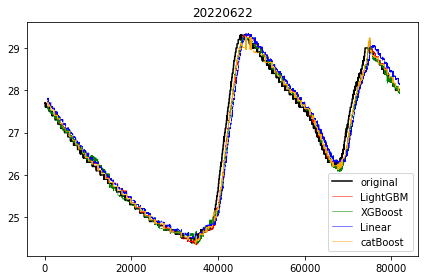

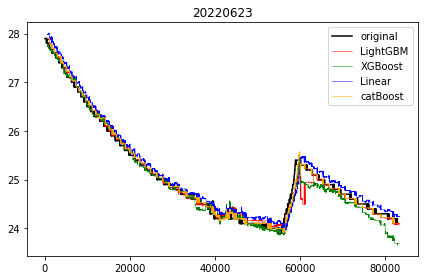

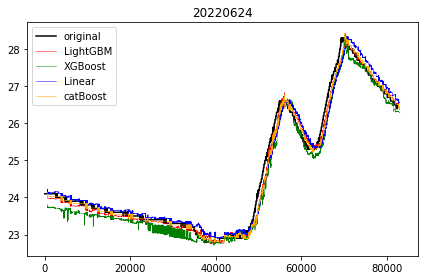

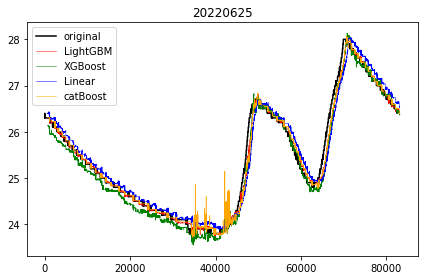

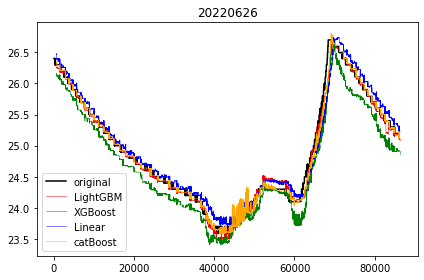

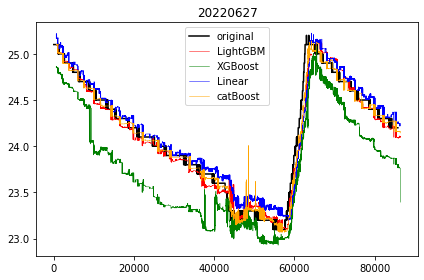

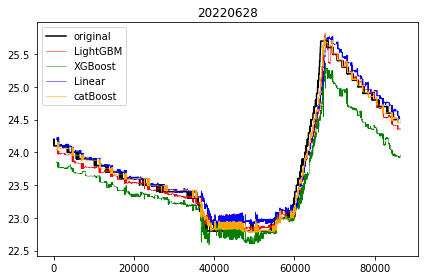

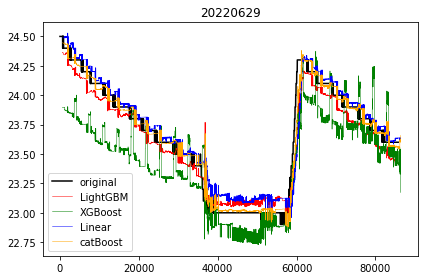

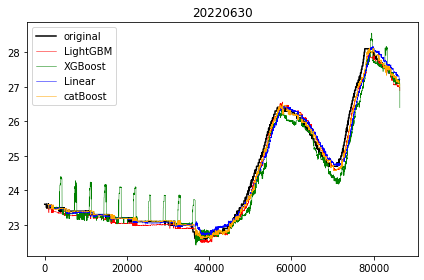

In [9]:
from datetime import datetime
import numpy as np
from sklearn.metrics import mean_squared_error


def date_range(start, end):
    start = datetime.strptime(start, "%Y%m%d")
    end = datetime.strptime(end, "%Y%m%d")
    dates = [date.strftime("%Y%m%d") for date in pd.date_range(start, periods=(end-start).days+1)]
    return dates

path = "./forecasting_data/"

save_f = "./figure/" + label + "/"

for valid_date in valid_dates:
    try:
        valid = pd.read_feather(path + valid_date + "/rack.feather")[sel_features]

        validX = valid.iloc[:-600,:]
        validY = valid.reset_index(drop=True).loc[600:,label].reset_index(drop=True)

        lgb_pred = lgb_model.predict(validX)
        xgb_pred = xgb_model.predict(validX)
        linear_pred = linear_reg.predict(validX)
        cat_pred = cat_model.predict(validX)
    except:
        continue
    '''
    plt.subplot(2,3,1)
    plt.hist(validY, range=(3.2,4.2), color = 'b', label = 'original')
    
    plt.subplot(2,3,2)
    plt.hist(lgb_pred, range=(3.2,4.2), color = 'orange', label = 'prediction(LightGBM)')
    
    plt.subplot(2,3,3)
    plt.hist(xgb_pred, range=(3.2,4.2), color = 'green', label = 'prediction(XGBoost)')
    
    plt.subplot(2,3,6)
    plt.plot(range(len(validY)),validY, color='black', label = 'original')
    
    
    ax0 = plt.subplot2grid((2, 3), (0, 0), rowspan=1, colspan=1)
    ax1 = plt.subplot2grid((2, 3), (0, 1), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((2, 3), (0, 2), rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((2, 3), (1, 0), rowspan=1, colspan=3)

    ax0.hist(validY, range=(3.2,4.2), color = 'b', label = 'original')
    ax1.hist(lgb_pred, range=(3.2,4.2), color = 'orange', label = 'LightGBM')
    #ax2.hist(xgb_pred, range=(3.2,4.2), color = 'green', label = 'XGBoost')
    ax2.hist(linear_pred, range=(3.2,4.2), color = 'green', label = 'Linear')
    
    length = len(validY)
    ax3.plot(range(len(validY)),validY, color='black', label = 'original')
    ax3.plot(range(600,length+600), lgb_pred, color = 'orange', label = 'prediction')
    #ax3.plot(range(600,length+600), xgb_pred, color = 'green', label = 'prediction')
    ax3.plot(range(600,length+600), linear_pred, color = 'green', label = 'prediction')
    
    ax0.legend(loc='upper left')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    '''
    length = len(validY)
    
    plt.plot(range(len(validY)),validY, color='black', label = 'original')
    plt.plot(range(600,length+600), lgb_pred, color = 'r', linewidth = 0.5, label = 'LightGBM')
    plt.plot(range(600,length+600), xgb_pred, color = 'g', linewidth = 0.5, label = 'XGBoost')
    plt.plot(range(600,length+600), linear_pred, color = 'b', linewidth = 0.5, label = 'Linear')
    plt.plot(range(600,length+600), cat_pred, color = 'orange', linewidth = 0.5, label = 'catBoost')
    
    plt.legend()
    
    plt.title(valid_date)
    
    plt.tight_layout()
    plt.savefig(save_f+f"{valid_date}.jpg", dpi=600)
    
    plt.show()

In [10]:
import joblib

save_model_path = "./model/" + label + "/"

joblib.dump(lgb_model, save_model_path + "lgb_model.pkl") 
joblib.dump(xgb_model, save_model_path + "xgb_model.pkl") 
joblib.dump(linear_reg, save_model_path + "linear_model.pkl") 
joblib.dump(cat_model, save_model_path + "cat_model.pkl") 

['./model/RACK_MIN_CELL_TEMPERATURE/cat_model.pkl']